In [2]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data as train parameter is set to false
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
from torch import nn, optim
import torch.nn.functional as F

# Normal NN with no regularization
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [4]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps) # this will give us the probabilities
                # This returns a tuple of the top-$k$ values and the top-$k$ indices. 
                # If the highest value is the fifth element, we'll get back 4 as the index.
                # Since we just want the most likely class, we can use ps.topk(1)
                top_p, top_class = ps.topk(1, dim=1)
                
                # What it's doing is comparing the one element in each row of top_class with
                # each element in labels which returns 64 True/False boolean values for each row.
                equals = top_class == labels.view(*top_class.shape)
                
                #equals has type torch.ByteTensor but torch.mean isn't implement
                # for tensors with that type. So we'll need to convert equals to a float tensor. 
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 0.516..  Test Loss: 0.469..  Test Accuracy: 0.828
Epoch: 2/30..  Training Loss: 0.387..  Test Loss: 0.415..  Test Accuracy: 0.851
Epoch: 3/30..  Training Loss: 0.359..  Test Loss: 0.392..  Test Accuracy: 0.858
Epoch: 4/30..  Training Loss: 0.336..  Test Loss: 0.388..  Test Accuracy: 0.860
Epoch: 5/30..  Training Loss: 0.319..  Test Loss: 0.403..  Test Accuracy: 0.855
Epoch: 6/30..  Training Loss: 0.303..  Test Loss: 0.377..  Test Accuracy: 0.867
Epoch: 7/30..  Training Loss: 0.292..  Test Loss: 0.366..  Test Accuracy: 0.873
Epoch: 8/30..  Training Loss: 0.288..  Test Loss: 0.388..  Test Accuracy: 0.862
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.369..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.266..  Test Loss: 0.363..  Test Accuracy: 0.872
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.361..  Test Accuracy: 0.882
Epoch: 12/30..  Training Loss: 0.253..  Test Loss: 0.405..  Test Accuracy: 0.868
Epoch: 13/30..  Training Loss: 0.250.

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

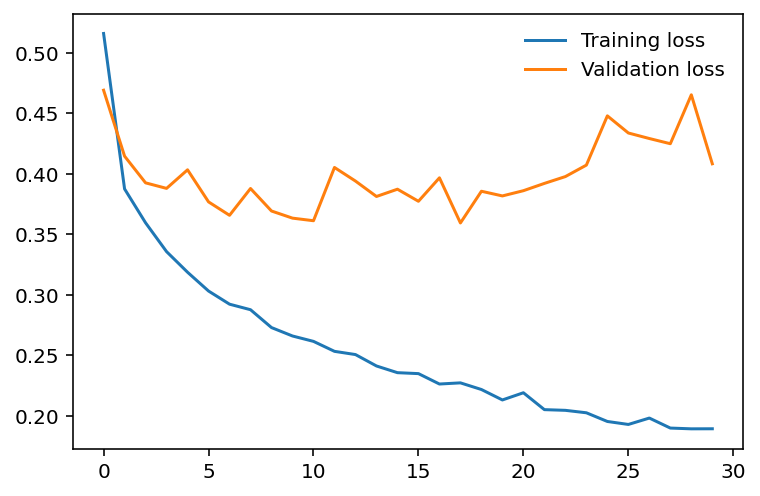

In [6]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [10]:
class RegularizedClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [11]:
model = RegularizedClassifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    # training pass
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        # validation pass
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # During training we want to use dropout to prevent overfitting, 
            # but during inference we want to use the entire network. 
            # So, we need to turn off dropout during validation, testing, and 
            # whenever we're using the network to make predictions. 
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # set model back to train mode
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.605..  Test Loss: 0.528..  Test Accuracy: 0.805
Epoch: 2/30..  Training Loss: 0.477..  Test Loss: 0.461..  Test Accuracy: 0.848
Epoch: 3/30..  Training Loss: 0.451..  Test Loss: 0.421..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.436..  Test Loss: 0.428..  Test Accuracy: 0.846
Epoch: 5/30..  Training Loss: 0.427..  Test Loss: 0.406..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.413..  Test Loss: 0.393..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.402..  Test Loss: 0.398..  Test Accuracy: 0.859
Epoch: 8/30..  Training Loss: 0.396..  Test Loss: 0.392..  Test Accuracy: 0.863
Epoch: 9/30..  Training Loss: 0.396..  Test Loss: 0.413..  Test Accuracy: 0.851
Epoch: 10/30..  Training Loss: 0.388..  Test Loss: 0.394..  Test Accuracy: 0.859
Epoch: 11/30..  Training Loss: 0.385..  Test Loss: 0.399..  Test Accuracy: 0.864
Epoch: 12/30..  Training Loss: 0.382..  Test Loss: 0.408..  Test Accuracy: 0.853
Epoch: 13/30..  Training Loss: 0.380.

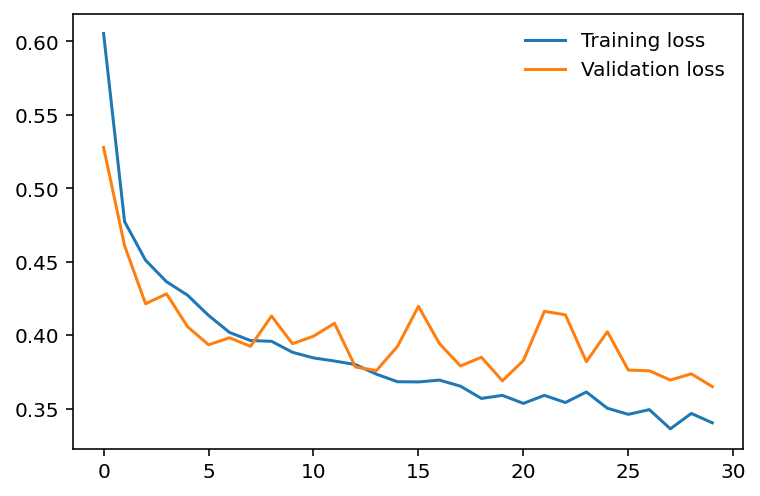

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)